#  Entreprise OLIST

Ce notebook présente les caractéristiques de stabilité du modèle de clustering par algorythme Kmeans.

L'objectif du notebook est de représenter le comportement du clustering au fil des mois et de valider une périodicité pour la mise à jour de l'entrainement du modèle.




## Imports
Nous utiliserons les library standard de datascience : `numpy`, `pandas`, `sklearn`, `matplotlib`. 

In [2]:
import numpy as np
import pandas as pd 
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE

from yellowbrick.cluster import KElbowVisualizer, silhouette_visualizer,SilhouetteVisualizer

import folium

import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')




pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [3]:
def inspect_dupes(df, dedupe=False):
    '''
    Checks duplicates (rows), and gets rid of duplicates if dedupe arg set to 'True' 
    Arg: dataframe, dedupe (bool)
    '''
    num_of_dupe = len(df[df.duplicated()])

    if dedupe and num_of_dupe>0: 
        df.drop_duplicates(inplace=True)
        print(f'Number of duplicates found: {num_of_dupe}')
        return df

    else: 
        print(f'Number of duplicates found: {num_of_dupe}')
        return num_of_dupe
    
def iqr(df,drop=False):
   
    cols_to_keep = [col for col in df.columns if df[col].nunique() > 2]
    dataframe = df[cols_to_keep]
    
    iqr_analysis_list = []

    # Sélection des variables numériques
    numeric_variables = dataframe.select_dtypes(include=['number'])
    l_ind_outlier=[]
    
    for variable_name in numeric_variables.columns:
        # Calcul de l'analyse IQR pour chaque variable numérique
        variable_data = dataframe[variable_name]
        
        # Calcul des quartiles
        Q1 = variable_data.quantile(0.25)
        Q3 = variable_data.quantile(0.75)
        
        # Calcul de l'IQR (Interquartile Range)
        IQR = Q3 - Q1
        
        # Détermination des limites inférieure et supérieure pour détecter les valeurs aberrantes
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Exclusion des individus aberrants
        excluded_count = ((variable_data < lower_bound) | (variable_data > upper_bound)).sum()
        
        # Calcul du ratio d'exclusion
        total_count = len(variable_data)
        exclusion_ratio = excluded_count / total_count
        
        # Ajout des résultats dans une liste
        iqr_analysis_list.append({
            'Variable': variable_name,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Excluded Count': excluded_count,
            'Exclusion Ratio': exclusion_ratio
        })

        # Filtrer les valeurs en dehors des bornes IQR
        l_ind_outlier += dataframe[(dataframe[variable_name] <= lower_bound) |
                                   (dataframe[variable_name] >= upper_bound)].index.to_list()

    l_ind_outlier=set(l_ind_outlier)
    print(len(l_ind_outlier))
    
    if drop == True :
        dataframe=dataframe.drop(l_ind_outlier,axis=0)
    # Création d'un dataframe à partir de la liste des résultats
    iqr_analysis_df = pd.DataFrame(iqr_analysis_list)
    display(iqr_analysis_df.sort_values(by='Exclusion Ratio',ascending=False))
    
    return dataframe    
    
    
 # Réduit le nombre de décimale
def format_value(x):
    try:
        return f"{x:.2f}"
    except:
        return str(x)
    
  # Explorations de base du df  
def desc(df):
    print( '************************************')  
    print( '      Descriptif du dataset')
    print( '************************************')  
    print(f'Le dataset est composé de {df.shape[0]} individus et {df.shape[1]} variables.')
    display(df.head())
    display(df.dtypes)
    display(df.describe())
    display(bilan_null(df).sort_values(by='Missing ratio',ascending = True))

  # Renvoie un df avec les Nunique et des infos sur les NaN      
def bilan_null(df):
    df_bilan=pd.concat([df.nunique(),
                        df.isnull().mean(),
                        df.isnull().sum(),
                        df.notnull().sum()],
                        axis=1,
                        keys=['Nunique','Missing ratio','Null count','Notnull count'])
    return df_bilan.sort_values(by='Missing ratio')

# Fonction pour encoder les variables catégorielles
def cat_enc(df) :

    le = LabelEncoder()
    le_count = 0

    # Iterate through the columns
    for col in df:
        if df[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 2:
                # Train on the training data
                le.fit(df[col])
                # Transform both training and testing data
                df[col] = le.transform(df[col])
                # Keep track of how many columns were label encoded
                le_count += 1

    print('%d columns were label encoded.' % le_count)
    # one-hot encoding of categorical variables
    df = pd.get_dummies(df,dtype=int)

    print('Training Features shape: ', df.shape)
    
    return df
def plot_target_cat(df, cat):

        plt.figure(figsize=(10, 6))
        sns.countplot(x=cat, hue="TARGET", data=df)
        plt.title("Effectifs de {} par {}".format(cat, "TARGET"))
        plt.xlabel(cat)
        if max([len(str(i)) for i in df[cat].unique()]) > 15:
            plt.xticks(rotation=45)
        if max([len(str(i)) for i in df[cat].unique()]) > 20:
            plt.xticks(rotation=90)
        plt.ylabel("Effectifs")
        plt.legend(title="TARGET", loc='upper right')
        plt.show()
        raw_df.groupby(cat)["TARGET"].mean().plot(kind='bar')    
        plt.title("Moyenne de défaut de paiement")
        if max([len(str(i)) for i in df[cat].unique()]) < 15:
            plt.xticks(rotation=0)
        if max([len(str(i)) for i in df[cat].unique()]) > 15:
            plt.xticks(rotation=45)
        if max([len(str(i)) for i in df[cat].unique()]) > 20:
            plt.xticks(rotation=90)
        plt.show()

def plot_target_num(df, numerical_column):

    # Création des bins
    df['bins'] = pd.cut(df[numerical_column], bins=11,precision=0)
    # Calcul de la moyenne de la cible pour chaque bin
    mean_target = df.groupby('bins')["TARGET"].mean()

    plt.figure(figsize=(10, 6))
    sns.countplot(x=df['bins'], hue="TARGET", data=df)
    plt.title("Effectifs de {} par {}".format(numerical_column, "TARGET"))
    plt.xlabel(numerical_column)
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 15:
        plt.xticks(rotation=45)
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 20:
        plt.xticks(rotation=90)
    plt.ylabel("Effectifs")
    plt.legend(title="TARGET", loc='upper right')
    plt.show()    
        
    
    # Tracé du barplot
    plt.figure(figsize=(10, 6))
    mean_target.plot(kind='bar')
    plt.title("Moyenne de défaut de paiement")
    plt.xlabel(numerical_column)
    plt.ylabel(('%'))
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 15:
        plt.xticks(rotation=45)
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 20:
        plt.xticks(rotation=90)
    plt.show()        

def plot_variables(df):
  #  # Plot categorical variables
  #  categorical_cols = df.select_dtypes(include=['object']).columns
  #  for col in categorical_cols:
  #      plt.figure(figsize=(8, 6))
  #      sns.countplot(data=df.sort_values(by=col), x=col)
  #      plt.title(f'{col} Distribution')
  #      plt.xticks(rotation=90)
  #      plt.show()
#
    # Plot numerical variables
    numerical_cols = df.select_dtypes(include=['int', 'float']).columns
    for col in numerical_cols:
        plt.figure(figsize=(8, 6))
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'{col} Distribution')
        plt.axvline(df[col].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
        plt.axvline(df[col].median(), color='green', linestyle='dashed', linewidth=2, label='Median')
        _, p_value = stats.normaltest(df[col].dropna())
        if p_value < 0.05:
            plt.text(1, 0.8, f'p-value: {p_value:.4f}\nNot normally distributed', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10, color='red')
        else:
            plt.text(1, 0.8, f'p-value: {p_value:.4f}\nNormally distributed', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10, color='green')
        plt.legend()
        plt.show()
        
def plot_roc_curves(y_true, d_res):

    plt.figure(figsize=(8, 6))
    for label in d_res :
        print(label)
        print(y_true.shape)
        print(d_res[label][2][:,1].shape)
        if label != 'DummyClassifier' :
            fpr, tpr, _ = roc_curve(y_true, d_res[label][2][:,1])
            auc = roc_auc_score(y_true, d_res[label][2][:,1])
            plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbes ROC')
    plt.legend()
    plt.show()
    
def make_confusion_matrix(y_true,
                          y_pred,
                          y_pred_proba=0,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''

    cf=confusion_matrix(y_true, y_pred)

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks
    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1,1] / np.sum(cf[:,1])
            recall    = cf[1,1] / np.sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            HC_score  = custom_cost(y_true,y_pred)
            auc       = roc_auc_score(y_true, y_pred_proba)
            stats_text = '''
           
HC Score  = {:0.3f}
Accuracy  = {:0.3f}
Precision = {:0.3f}
Recall    = {:0.3f}
F1 Score  = {:0.3f}
                 
ROC AUC   = {:0.3f}
                        '''.format(
                HC_score, accuracy, precision, recall, f1_score, auc)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


def search_score(titre, model,  param, n_job, X_train, y_train, X_test, y_test) :
   
    clf = model 
    
    param_grid = param

    model_opt = RandomizedSearchCV(clf,
                                   param_grid,
                                   cv=2,
                                   n_iter=200,
                                   verbose=1,
                                   scoring=HC_scorer,
                                   n_jobs=n_job,
                                   random_state=42,
                                   refit=True )
    
    model_opt = model_opt.fit(X_train, y_train)


    fpr, tpr, thr = roc_curve(y_test, model_opt.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    
    y_true= y_test
    y_pred = model_opt.predict(X_test)
    y_pred_proba = model_opt.predict_proba(X_test)[:,1]
    
    make_confusion_matrix(y_true, y_pred,  y_pred_proba=y_pred_proba)
    
    d_res[titre]=[
                    roc_auc,
                    custom_cost(y_test,model_opt.predict(X_test)),
                    model_opt.predict_proba(X_test)
                   ]    
   
    results = model_opt.cv_results_

    # Créer un DataFrame avec les informations pertinentes
    df_results = pd.DataFrame({
        'rank_test_score': results['rank_test_score'],
        'mean_test_score': results['mean_test_score'],
        'params': results['params']
    })
    # Extraire les paramètres individuels
    params_df = pd.json_normalize(df_results['params'])

    # Combiner les résultats avec les paramètres
    df_results_combined = pd.concat([df_results.drop(columns=['params']), params_df], axis=1)

    # Trier le DataFrame par rang
    df_results_sorted = df_results_combined.sort_values(by='rank_test_score')


    # Afficher les trois meilleurs résultats
    top_5_results = df_results_sorted.head(5)

    # Afficher les résultats sous forme de tableau
    display(top_5_results)
    
    return model_opt

def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

def display_factorial_planes(   X_projected,
                                x_y,
                                pca=None,
                                labels = None,
                                clusters=None,
                                alpha=1,
                                figsize=[10,8],
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments :
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments :
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8]
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7,6)

    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e

    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")

    # on définit x et y
    x, y = x_y

    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters

    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else :
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) :
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

##  Chargement des données

df_o = orders_202405281111.csv  
df_i = order_items_202405281111.csv  
df_c = customers_202405281111.csv  
df_r = order_reviews_202405281111.csv  
df_g = extract_groupby.csv  => Résultat de l'aggrégation de feature après l'extraction avec jointure

Requete SQL
> SELECT customer_unique_id,
       COUNT(order_purchase_timestamp) AS COUNT_sale,   
       AVG(review_score) AS AVG_review_score,  
       AVG(price) AS AVG_price,  
       MIN(price) AS MIN_price,  
       MAX(price) AS MAX_price,  
       SUM(price) AS SUM_price,  
       JULIANDAY(DATE('2018-10-17 17:30:18') ) - JULIANDAY(MIN(DATE(order_purchase_timestamp) ) ) AS first_sale,  
       JULIANDAY(DATE('2018-10-17 17:30:18') ) - JULIANDAY(MAX(DATE(order_purchase_timestamp) ) ) AS last_sale,  
       customer_state,  
       review_comment_message,  
       order_status  
  FROM orders o  
       LEFT JOIN  
       customers c ON o.customer_id = c.customer_id  
       LEFT JOIN  
       order_reviews re ON o.order_id = re.order_id  
       LEFT JOIN  
       order_items oi ON o.order_id = oi.order_id  
 GROUP BY customer_unique_id  


Commençons par visualiser 'application_train.csv' : 

In [9]:
# Training data
df_o = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\data\\orders_202405281111.csv')
df_i = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\data\\order_items_202405281111.csv')
df_c = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\data\\customers_202405281111.csv')
df_r = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\data\\order_reviews_202405281111.csv')
df_g = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\extract_groupby.csv')

In [10]:
df_o.groupby('order_status').count()

,index,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_status,,,,,,,,
approved,2,2,2,2,2,0,0,2
canceled,625,625,625,625,484,75,6,625
created,5,5,5,5,0,0,0,5
delivered,96478,96478,96478,96478,96464,96476,96470,96478
invoiced,314,314,314,314,314,0,0,314
processing,301,301,301,301,301,0,0,301
shipped,1107,1107,1107,1107,1107,1107,0,1107
unavailable,609,609,609,609,609,0,0,609


In [14]:
df_o.drop('index',axis=1,inplace=True)

In [15]:
df_merged1 =       df_o.merge(df_c, on= 'customer_id', how='left')
df_merged2 = df_merged1.merge(df_r, on= 'order_id', how='left')
df_merged3 = df_merged2.merge(df_i, on= 'order_id', how='left')

In [16]:
bilan_null(df_merged1)
bilan_null(df_merged2)
bilan_null(df_merged3)

,Nunique,Missing ratio,Null count,Notnull count
order_id,99441,0.000000,0,114092
customer_id,99441,0.000000,0,114092
order_status,8,0.000000,0,114092
order_purchase_timestamp,98875,0.000000,0,114092
order_estimated_delivery_date,459,0.000000,0,114092
index_x,99441,0.000000,0,114092
customer_unique_id,96096,0.000000,0,114092
customer_zip_code_prefix,14994,0.000000,0,114092
customer_city,4119,0.000000,0,114092
customer_state,27,0.000000,0,114092


In [17]:
df_merged3['order_purchase_timestamp'] =  pd.to_datetime(df_merged3['order_purchase_timestamp']) 
df_merged3['diff'] =pd.to_datetime('2018-10-17 17:30:18') - df_merged3['order_purchase_timestamp'] 
df_merged3['diff']=df_merged3['diff'].map(lambda x : x.days)

df3_gr = df_merged3.groupby('customer_unique_id', as_index=False, dropna=False).agg( 
    COUNT_sale=('order_purchase_timestamp', 'count'),
    SUM_price=('price', 'sum'),
    last_sale=('diff', 'min'),
    AVG_review_score=('review_score', 'mean')
)

df3_gr['AVG_review_score'].fillna(df3_gr['AVG_review_score'].median(), inplace=True)
df3_gr.fillna(0, inplace=True)



Faisons un point d'arrêt pour vérifier que nos données fusionnées cette fois-ci en python (df3_gr) correspondent bien à l'extract réalisé en SQL lors de la partie précédente (df_g) 

In [18]:
df3_gr.describe()

,COUNT_sale,SUM_price,last_sale,AVG_review_score
count,96096.000000,96096.000000,96096.000000,96096.000000
mean,1.187271,142.065471,287.735691,4.091513
std,0.650974,218.435272,153.414676,1.339311
min,1.000000,0.000000,0.000000,1.000000
25%,1.000000,46.000000,163.000000,4.000000
50%,1.000000,89.000000,268.000000,5.000000
75%,1.000000,154.990000,397.000000,5.000000
max,24.000000,13440.000000,772.000000,5.000000


In [19]:
df_g = df_g[['COUNT_sale','SUM_price','last_sale','AVG_review_score']]
df_g['AVG_review_score'].fillna(df_g['AVG_review_score'].median(), inplace=True)
df_g.fillna(0, inplace=True)

df_g.describe()

,COUNT_sale,SUM_price,last_sale,AVG_review_score
count,96096.000000,96096.000000,96096.000000,96096.000000
mean,1.187271,142.065471,288.108797,4.091513
std,0.650974,218.435272,153.417869,1.339311
min,1.000000,0.000000,0.000000,1.000000
25%,1.000000,46.000000,164.000000,4.000000
50%,1.000000,89.000000,269.000000,5.000000
75%,1.000000,154.990000,397.000000,5.000000
max,24.000000,13440.000000,773.000000,5.000000


Les données correspondent, le merge s'est bien passé.

Nous pouvons revenir à notre préparation de données en constituant une liste de dataframe distribuée sur une fréquence de 2 mois :

In [21]:
# sample data
df = df_merged3
df['review_score'].fillna(df['review_score'].median(), inplace=True)
df.fillna(0, inplace=True)
display(df)
# groupby your key and freq
g = df.groupby(pd.Grouper(key='order_purchase_timestamp', freq='2M'))
# groups to a list of dataframes with list comprehension
dfs = [group for _,group in g]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_y,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,70296,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,32790.0,a54f0611adc9ed256b57ede6b6eb5114,4.0,0,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,100785.0,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,380
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,77027,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,29158.0,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,36896.0,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,84
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,554,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,4323.0,e73b67b67587f7644d5bd1a52deb1b01,5.0,0,0,2018-08-18 00:00:00,2018-08-22 19:07:58,31504.0,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,70
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,61081,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,77520.0,359d03e676b3c069f62cadba8dd3f6e8,5.0,0,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58,65021.0,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,332
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,67263,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,54136.0,e50934924e227544ba8246aeb3770dd4,5.0,0,0,2018-02-17 00:00:00,2018-02-18 13:02:51,76043.0,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114087,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,78424,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,55670.0,29bb71b2760d0f876dfa178a76bc4734,4.0,0,So uma peça que veio rachado mas tudo bem rs,2018-03-01 00:00:00,2018-03-02 17:50:01,43826.0,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,253
114088,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,19901,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,43847.0,371579771219f6db2d830d50805977bb,5.0,0,Foi entregue antes do prazo.,2017-09-22 00:00:00,2017-09-22 23:10:57,57884.0,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,416
114089,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018

Period from 2016-09-04 21:15:19 to 2016-09-15 12:16:38
Total sale :  7
 --------------------------- 
Period from 2016-10-02 22:07:52 to 2016-10-22 08:25:27
Total sale :  383
 --------------------------- 
Period from 2016-12-23 23:16:47 to 2017-01-31 23:37:58
Total sale :  978
 --------------------------- 
Period from 2017-02-01 00:04:17 to 2017-03-31 23:54:45
Total sale :  5070
 --------------------------- 
Period from 2017-04-01 00:54:10 to 2017-05-31 22:59:52
Total sale :  6928
 --------------------------- 
Period from 2017-06-01 00:05:38 to 2017-07-31 23:55:27
Total sale :  8269
 --------------------------- 
Period from 2017-08-01 00:02:01 to 2017-09-30 23:59:15
Total sale :  9910
 --------------------------- 
Period from 2017-10-01 00:03:33 to 2017-11-30 23:36:03
Total sale :  14255
 --------------------------- 
Period from 2017-12-01 00:01:14 to 2018-01-31 23:58:22
Total sale :  14696
 --------------------------- 
Period from 2018-02-01 00:24:55 to 2018-03-31 23:54:10
Total sale :

<Axes: >

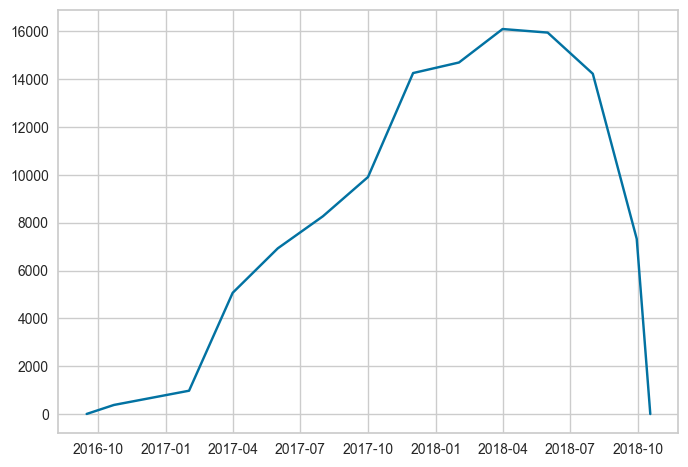

In [123]:
L_vente = []
L_date = []

for df_period in dfs :
    print(f'Period from {df_period['order_purchase_timestamp'].min()} to {df_period['order_purchase_timestamp'].max()}')
    print('Total sale : ', df_period['order_purchase_timestamp'].count())
    print(' --------------------------- ')
    L_vente.append(df_period['order_purchase_timestamp'].count())
    L_date.append(df_period['order_purchase_timestamp'].max())
    

sns.lineplot(x=L_date,y=L_vente,)

Le début d'année 2016 et la fin d'année 2018 présentent nettement moins de commandes que le reste de l'année.   


### Méthodologie 

Dans la suite du notebook, nous allons simuler le comportement du clustering au fil du temps. 

Nous allons procéder en 4 étapes :

* 1 Définition d'une valeur initiale des clusters sur les 12 premiers mois
* 2 Ajout progressif de nouvelles données tous les deux mois
* 3 Évaluation du clustering par la métrique adjusted_rand_score
* 4 Définition de la périodicité de la maintenance


In [20]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

# Placeholder to store ARI scores
ari_scores = []
n_init = 7

df_init = pd.concat(dfs[:n_init])
display('''Début de la période d'initialisation : ''',df_init['order_purchase_timestamp'].min())
display('''Fin de la période d'initialisation : ''',df_init['order_purchase_timestamp'].max())
df_init_gr = df_init.groupby('customer_unique_id', as_index=True, dropna=False).agg(
        COUNT_sale=('order_purchase_timestamp', 'count'),
        SUM_price=('price', 'sum'),
        last_sale=('diff', 'min'),
        AVG_review_score=('review_score', 'mean')
)


df_init_gr = df_init_gr[['last_sale', 'COUNT_sale', 'SUM_price', 'AVG_review_score']]
df_init_gr['R_score'] = pd.cut(df_init_gr['last_sale'], bins=[-0.001, 142.0, 227.0, 317.0, 433.0, np.inf], labels=[5, 4, 3, 2, 1])
df_init_gr['F_score'] = pd.cut(df_init_gr['COUNT_sale'], bins=[0.5, 1.5, 2.5, np.inf], labels=[1, 3, 5])
df_init_gr['M_score'] = pd.cut(df_init_gr['SUM_price'], bins=[-0.001, 39.0, 69.0, 109.9, 179.9, np.inf], labels=[1, 2, 3, 4, 5])
df_init_gr['H_score'] = pd.cut(df_init_gr['AVG_review_score'], bins=[-0.001, 1.8, 2.6, 3.4, 4.2, 5.1], labels=[1, 2, 3, 4, 5])



df_init_gr = df_init_gr[['R_score', 'F_score', 'M_score', 'H_score']]


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=5, random_state=42))
])

pipeline.fit(df_init_gr)

y_init = pipeline.predict(df_init_gr)

df_init_gr = pd.concat([df_init_gr,pd.DataFrame(y_init, columns=['Clusters'], index=df_init_gr.index)],axis=1)

display(df_init_gr)







# Iterate over time periods
for df_m in dfs[n_init:-1] :
    print('---------------------------')
   
    df_curr = df_init.combine_first(df_m)
    display(df_m.shape)    
    display(df_init.shape)
    display(df_curr.shape)
    
    
    df_init = df_curr.copy()

    df_curr_gr = df_curr.groupby('customer_unique_id', as_index=True, dropna=False).agg(
    COUNT_sale=('order_purchase_timestamp', 'count'),
    SUM_price=('price', 'sum'),
    last_sale=('diff', 'min'),
    AVG_review_score=('review_score', 'mean')
    )
    df_curr_gr = df_curr_gr[['last_sale', 'COUNT_sale', 'SUM_price', 'AVG_review_score']]
    df_curr_gr['R_score'] = pd.cut(df_curr_gr['last_sale'], bins=[-0.001, 142.0, 227.0, 317.0, 433.0, np.inf], labels=[5, 4, 3, 2, 1])
    df_curr_gr['F_score'] = pd.cut(df_curr_gr['COUNT_sale'], bins=[0.5, 1.5, 2.5, np.inf], labels=[1, 3, 5])
    df_curr_gr['M_score'] = pd.cut(df_curr_gr['SUM_price'], bins=[-0.001, 39.0, 69.0, 109.9, 179.9, np.inf], labels=[1, 2, 3, 4, 5])
    df_curr_gr['H_score'] = pd.cut(df_curr_gr['AVG_review_score'], bins=[-0.001, 1.8, 2.6, 3.4, 4.2, 5.1], labels=[1, 2, 3, 4, 5])

    df_curr_gr = df_curr_gr[['R_score', 'F_score', 'M_score', 'H_score']]

    print(f'Adding period from {df_m["order_purchase_timestamp"].min()} to {df_m["order_purchase_timestamp"].max()}')
    print('Total sale : ', df_curr['order_purchase_timestamp'].count())
    print('Total customer : ', df_curr_gr.shape[0])

    display(df_curr_gr)
    

    pipeline.fit(df_curr_gr)
    print(f' df_curr_gr shape : {df_curr_gr.shape}')
    y_curr = pipeline.predict(df_curr_gr)
    
    print(y_curr.shape)
  
    df_curr_gr = pd.concat([df_curr_gr, pd.DataFrame(y_curr, columns=['Clusters'], index=df_curr_gr.index)],axis=1)

    # df_tmp_init = pd.concat([df_init_gr, pd.DataFrame(y_init, columns=['Clusters'], index=df_init_gr.index)],axis=1)
    
    # y_init = y_curr
    
    # df_tmp_init = df_tmp_init.combine_first(df_tmp_curr)
    
    display('df_init_gr',df_init_gr)
    df_curr_gr.sort_index(inplace = True)
    display('df_curr_gr',df_curr_gr)
   
    new_rows = df_curr_gr[~df_curr_gr.index.isin(df_init_gr.index)]
    df_init_gr = pd.concat([df_init_gr, new_rows])
    df_init_gr.sort_index(inplace = True)
    display('df_init_gr MAJ',df_init_gr)
    
    
    # Calculate ARI between the previous period's true labels and the current period's clusters
    ari = adjusted_rand_score(df_init_gr['Clusters'], df_curr_gr['Clusters'])
    ari_scores.append(ari)
    print(ari)

# Convert to a DataFrame for easier plotting
periods = [f'Period {i+1}' for i in range(1, len(dfs[3:-2]))]
ari_df = pd.DataFrame({'Period': periods, 'ARI Score': ari_scores})

# Plot ARI Scores
plt.figure(figsize=(10, 6))
plt.plot(ari_df['Period'], ari_df['ARI Score'], marker='o', linestyle='-', color='b')
plt.title('ARI Score Over Time Periods')
plt.xlabel('Time Period')
plt.ylabel('ARI Score')
plt.grid(True)
plt.show()


NameError: name 'dfs' is not defined

In [54]:
for i in range(3, len(dfs[3:-2])):
    print(dfs[i].index)
 

Index([ 27866,  38485,  23191,  49029,  67784, 106863,  93217,  85263,  76111,
        33634,
       ...
        70930,  15602,  88396,  56451,   3849,   4530,   2398,  53451,  56523,
        95673],
      dtype='int64', length=5070)
Index([ 98094,  56933,  77894,  70864,  42626,  69086,  42643,  53302,  10698,
        23297,
       ...
        68278,  44279,  44280, 108516,  70963,  92468,  92469,  12720,  67287,
        20827],
      dtype='int64', length=6928)
Index([ 19457, 108807,  65000,  50711,  30299,  79573,  98292,  71337,  43473,
        77200,
       ...
        41451,  55260,  55261,  16747,  47074,   7502,  60171, 110216,   2943,
        95266],
      dtype='int64', length=8269)
Index([ 5232, 11221,  1603, 78420, 99085, 40827, 57200,  6393, 60552, 94291,
       ...
       97608, 65809, 38651, 38652, 52554, 29795, 57225, 87153, 50591,  4201],
      dtype='int64', length=9910)
Index([ 56770,  34102,  14810,  86565, 102983, 102984,  30334,  30335,  30336,
        30337,
    

In [24]:
ari_scores

[0,
 0.0007935679515120557,
 0.00013275358587682142,
 -0.0005235833916509017,
 -0.00044477205702263473,
 0.0005072996726241969]